<a href="https://colab.research.google.com/github/sahar7888/CheatSheet/blob/main/Pytorch_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from torch.utils.data.dataloader import default_collate
import os


In [2]:
# Function to generate random circular dataset
def generate_circular_dataset(n_samples, radius, noise):
    theta = np.random.rand(n_samples) * 2 * np.pi
    x = radius * np.cos(theta) + np.random.normal(scale=noise, size=n_samples)
    y = radius * np.sin(theta) + np.random.normal(scale=noise, size=n_samples)
    return np.column_stack((x, y))


In [3]:
# Generate random circular dataset for class 0 and class 1
n_samples = 1000
radius_0 = 3
radius_1 = 5
noise = 0.1

X_class_0 = generate_circular_dataset(n_samples // 2, radius_0, noise)
y_class_0 = np.zeros((n_samples // 2,), dtype=int)

X_class_1 = generate_circular_dataset(n_samples // 2, radius_1, noise)
y_class_1 = np.ones((n_samples // 2,), dtype=int)

X = np.vstack((X_class_0, X_class_1))
y = np.hstack((y_class_0, y_class_1))

In [4]:
# Shuffle the dataset
shuffle_idx = np.random.permutation(n_samples)
X = X[shuffle_idx]
y = y[shuffle_idx]

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # No need for dimensionality reduction in this case
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [7]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [8]:
# Define the model architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

In [9]:
# Create an instance of the model
model = NeuralNetwork()

In [10]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Define PyTorch dataset and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [12]:
# Train the model
num_epochs = 50
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_dataset)
    train_losses.append(train_loss)


In [17]:
# Evaluate the model on test data
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    test_loss = criterion(outputs, y_test_tensor.unsqueeze(1))
    test_losses.append(test_loss.item())
print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss.item():.4f}")

Epoch 50/50, Train Loss: 0.0307, Test Loss: 0.0031


In [21]:
# Evaluate the model
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    y_pred = torch.round(outputs).squeeze().numpy()
    test_loss = criterion(outputs, y_test_tensor.unsqueeze(1))
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0031


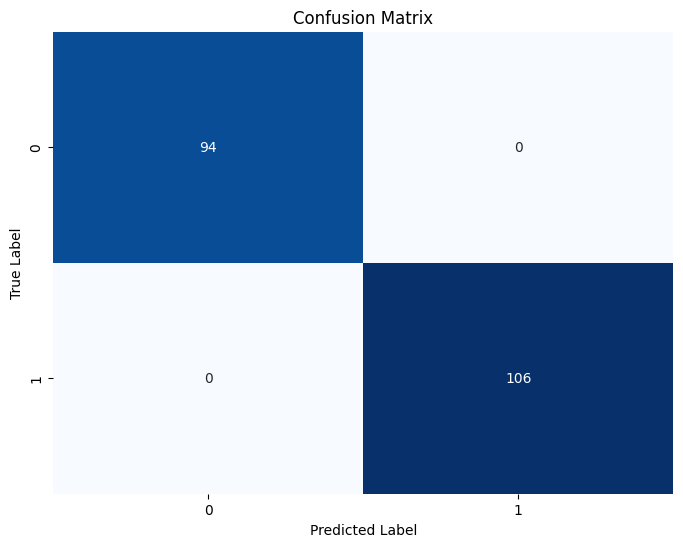

In [22]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

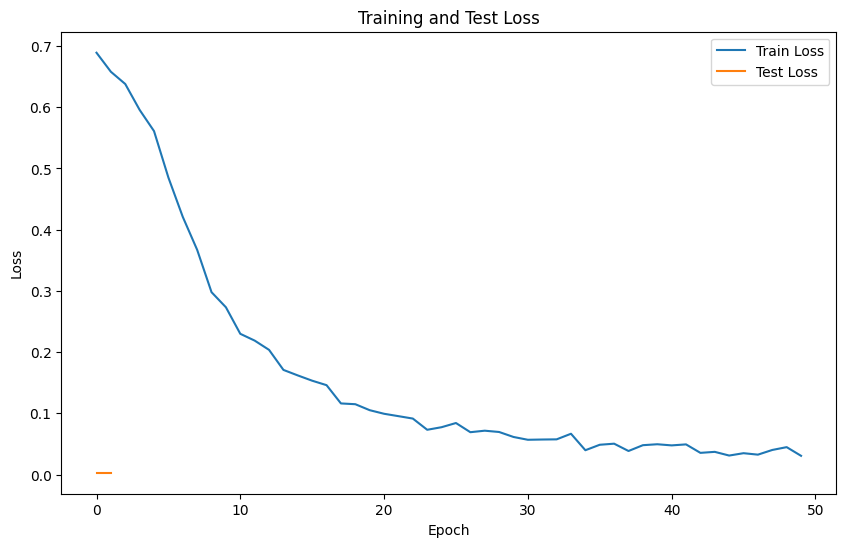

In [20]:
# Plot training and test loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Save the trained model
MODEL_PATH = "model.pth"
torch.save(model.state_dict(), MODEL_PATH)

# Reload the model
loaded_model = NeuralNetwork()
loaded_model.load_state_dict(torch.load(MODEL_PATH))
loaded_model.eval()

# Create new data for prediction
X_new = np.array([[2.5, 4.5], [4.0, 2.0]])  # Example new data
X_new_tensor = torch.tensor(X_new, dtype=torch.float32)

# Perform prediction using the loaded model
with torch.no_grad():
    predictions = loaded_model(X_new_tensor)
    y_pred = torch.round(predictions).squeeze().numpy()

# Print the predicted labels
for i, pred in enumerate(y_pred):
    print(f'Prediction for sample {i+1}: {pred}')

Prediction for sample 1: 1.0
Prediction for sample 2: 1.0
